# Chapter 4 - Policy Gradient Methods

In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt

In [2]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [3]:
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/unam9su/.local/share/virtualenvs/DeepReinforcementLearningInAction-fvkxvmmz/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


##### Listing 4.4

In [4]:
import gym
import numpy as np
import torch

l1 = 4   #1: input length = 4
l2 = 150 #2: mid layer: produces a vector of length 150
l3 = 2   #3: output length = 2 (e.g., left or right; softmax probability)

# a policy network
## input: state vectors
## output: (discrete) probability distribution over the possible actions
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0)
)

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


##### Listing 4.5

In [5]:
state1 = env.reset()
pred = model(torch.from_numpy(state1).float())   # 1: calls the policy network model to produce predicted action probabilities
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())  # 2: samples an action from the probability distribution produced by the policy network
state2, reward, done, info = env.step(action)  # 3: takes the action and receives the new state and reward.

##### Listing 4.6

In [6]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma, torch.arange(lenr).float()) * rewards # 1: computes exponentially decaying rewards
    disc_return /= disc_return.max()  # 2: normalizes the rewards to be within the [0, 1] intercal to improve numerical stability
    return disc_return

##### Listing 4.7

In [7]:
def loss_fn(preds, r):  #1: loss function - takes an array of action probabilities; and discounted rewards
    return -1 * torch.sum(r * torch.log(preds))  #2: computes the log probabilities - multiplies by the discounted rewards - sum - flips the sign

##### Listing 4.8

In [8]:
MAX_DUR = 200
MAX_EPISODES = 200
gamma = 0.995
score = [] #1: keeping track of the episode length over training
expectation = 0.0
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] #2: a list of state, action, rewards
    
    for t in range(MAX_DUR): #3: while in the episode
        act_prob = model(torch.from_numpy(curr_state).float()) #4: gets the action probabilities
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) #5: selects an action stochastically
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) #6: takes the action in the environment
        transitions.append((prev_state, action, t+1)) #7: stores this transition
        if done: #8: if the game is lost -> breaks out from the loop
            break

    ep_len = len(transitions) #9: stores the episode length
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) #10: collects all the rewards in the episode in a single tensor
    disc_returns = discount_rewards(reward_batch) #11: computes the discounted version of rewards
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) #12: collects the states in the episode in a single tensor
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) #13: collects the action in the episode in a single tensor
    pred_batch = model(state_batch) #14: recomputes the action probabilities for all the states in the episode
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() #15: subsets the action-probabilities associated with the actions that were actually taken
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [9]:
score = np.array(score)
avg_score = running_mean(score, 50)

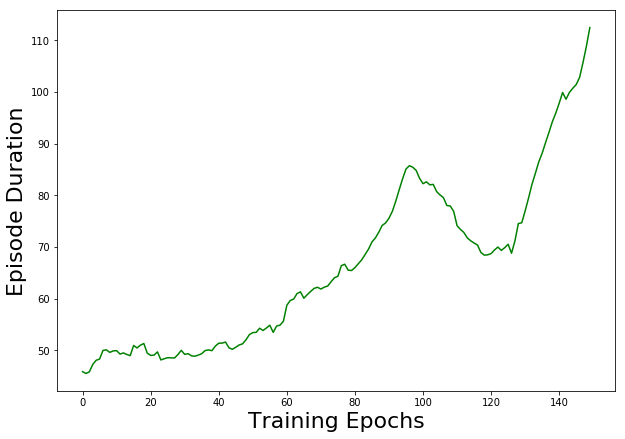

In [10]:
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

##### Listing 4.9

In [13]:
# test play with a trained model
score = []
games = 100  # will play 100 games to test the model
done = False
state1 = env.reset()
for i in range(games):
    t=0
    while not done: #F
        pred = model(torch.from_numpy(state1).float()) #predicts the action probabilities
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #selects the action stochastically
        state2, reward, done, info = env.step(action) #stores the action
        state1 = state2 
        t += 1
        if t > MAX_DUR: #if reaches the max play steps: break
            break;
    state1 = env.reset() # resets the status/state1
    done = False
    score.append(t) #store the max step of the game
score = np.array(score)

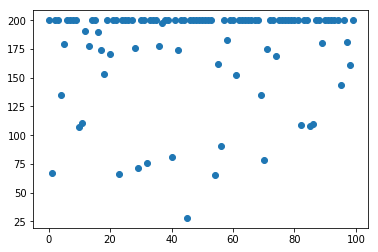

In [14]:
plt.scatter(np.arange(score.shape[0]),score)